# <center>Read Keystroke Data and Build Model to Process</center>

In [1]:
import os
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.cross_validation

input_path = "Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv"
print input_path;

Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv


## Import Raw Data and Extract Features. Pre-process the data 

### Dataset (The CMU keystroke dynamics dataset)

* The CMU benchmark dataset contains keystroke dynamics consisting of the dwell time for each key and the latencies between two successive keys for static password string “.tie5Roanl”.
* For each subject, there were data collection sessions with at least one day apart between two sessions. 50 repeated keystroke strings were collected in each session, resulting in a total 400 sample for each subject.
* For each typed 10-letter password and the final enter key, the dwell time and diagraphs give rise to a 31 dimensional feature vector.

Although the keystroke features provide sufficiently distinguishing patterns for each subject, they are highly correlated, with large scale variations, and typical of noise and outliers. Someone has previously proposed a new distance metric to effectively handle these challenges that are intrinsic to keystroke dynamics data.

In [2]:
file = open(input_path, "r");

raw_data = file.read();
print type(raw_data);

data_lines = np.array(raw_data.splitlines());
print data_lines[0];

data = np.array([x.split(",") for x in data_lines]);
data = np.delete(data, 0, 0);

# change username to index (0-50)
for i in range(len(data)):
    data[i][0] = i/400;

data = data.astype(np.float);
data_two = data[0:2*400];
data_user = np.array([data[i*400:(i+1)*400] for i in range(51)]);

print data.shape;
# print data;
print data_user.shape;
# print data_user;

<type 'str'>
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
(20400L, 34L)
(51L, 400L, 34L)


### Build train dataset and test dataset

In [3]:
# split data to train_data and test_data for cross validation

def pre_process(data, fold, shuffle):
    kf = sklearn.cross_validation.KFold(len(data), n_folds=fold, shuffle=shuffle);
    print kf;
    for train_index, test_index in kf:
        train, test = data[train_index], data[test_index];
        
    train_targets = train[:, 0:1].ravel();
    train_features = train[:, 3:];
    test_targets = test[:, 0:1].ravel();
    test_features = test[:, 3:];
    
    return train_targets, train_features, test_targets, test_features;
    

In [4]:

train_target, train_feature, test_target, test_feature = pre_process(data, 5, True);
train_target_two, train_feature_two, test_target_two, test_feature_two = pre_process(data_two, 5, True);

subjects = np.unique(train_target);
subjects_two = subjects[0:2];
n_classes = len(subjects);
n_classes_two = len(subjects_two);
print subjects;
print n_classes;

sklearn.cross_validation.KFold(n=20400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=800, n_folds=5, shuffle=True, random_state=None)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.]
51


### Train the SVM model to analyze data

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 
* The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.
* gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
* Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use sklearn.grid_search.GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

In [ ]:
clf = svm.SVC(gamma=1, C=300.);
clf2 = svm.SVC(gamma=1, C=300., decision_function_shape='ovo');
## for now, gamma = 1, C = 300 is my best combination of those two parameters in this model

#clf.fit(train_data, train_target);
clf2.fit(train_feature_two, train_target_two);
# libsvm = svm.libsvm.fit(x, y);

#print (clf, "\n", clf2);
print (clf2.score(test_feature_two, test_target_two));
print (sklearn.cross_validation.cross_val_score(clf, train_feature_two, train_target_two, cv=5));

# for i in range(20):
#     print (clf.predict(test_data[i]), test_target[i]);

    

### Use Neutral Network to analyze 
* In scikit-learn, the neural network model is Restricted Boltzmann machines (RBM). The features extracted by an RBM or a hierarchy of RBMs often give good results when fed into a linear classifier such as a linear SVM or a perceptron. 

* A Restricted Boltzmann Machine with binary visible units and binary hiddens. Parameters are estimated using Stochastic Maximum Likelihood (SML), also known as Persistent Contrastive Divergence (PCD)

* Two simple and easy search strategies for tuning parameter: Grid Search; Random Search

In [ ]:
# from sklearn.neural_network import BernoulliRBM
# from sklearn.cross_validation import train_test_split

# a = np.array([train_data[train_target == user] for user in subjects]);
# print a[0:5];
# print len(a[0]);


d = np.array([1, 2, 3, 4, 5]);
b = np.array(['1', '1', '2', '2', '4']);
c = np.array(['1', '2', '3', '4', '5']);
print np.array([d[b == x].mean() for x in c]);

### Gaussian Mixture Models with Universal Background Model
* A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions wih unknown parameters. (Gaussian Distribution = Normal Distribution)
* The GMM object implements the EM algorithm for fitting mixture-of-Gaussian models. 
* GMM.fit method learns a Gaussian Mixture Model from train data. Gmm.predict method can assign each sample of test data to the Gaussian class which it mostly probably belong to.
* The GMM has different options to constrain the covariance: spherical, diagonal, tied or full covariance. Since we have class labels for the training data, we can initialize the GMM parameters in a supervised manner.

In [5]:
## Draw the ellipses of the clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        

* Existing works in applying GMM to keystroke authentication is to train a GMM for each genuine user. At testing time, a keystroke feature is evaluated against the genuine user's GMM and a threshold is applied to the likelihood of the feature vector to make the decision.

* The idea of TMM-UBM is to train another GMM from a large pool of so-called background subjects (except the genuine user and the actual testing subjects). When the pool of background subjects is large enough, the UBM will have a good chance to reasonably represent any imposter's data. Thus, the imposter can have a relatively high likelihood score under UBM.

* A key common feature of these algorithms is that an unsupervised training is conducted on a large pool of subjects at the first stage to allow the classifier take advantage of the overall data distribution in the feature space for improved performance.

('spherical', GMM(covariance_type='spherical', init_params='wc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))
('Train_accuracy', 61.406249999999993)
('Test_accuracy', 60.624999999999993)
(41L, 31L)
(119L, 31L)
('diag', GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 52.812499999999993)
('Test_accuracy', 55.000000000000007)
(34L, 31L)
(126L, 31L)
('full', GMM(covariance_type='full', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 57.1875)
('Test_accuracy', 52.5)
(138L, 31L)
(22L, 31L)
('tied', GMM(covariance_type='tied', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001,

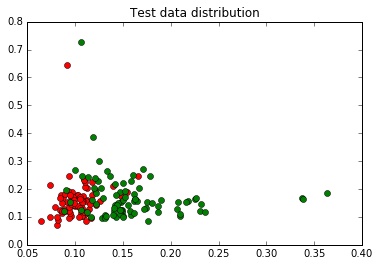

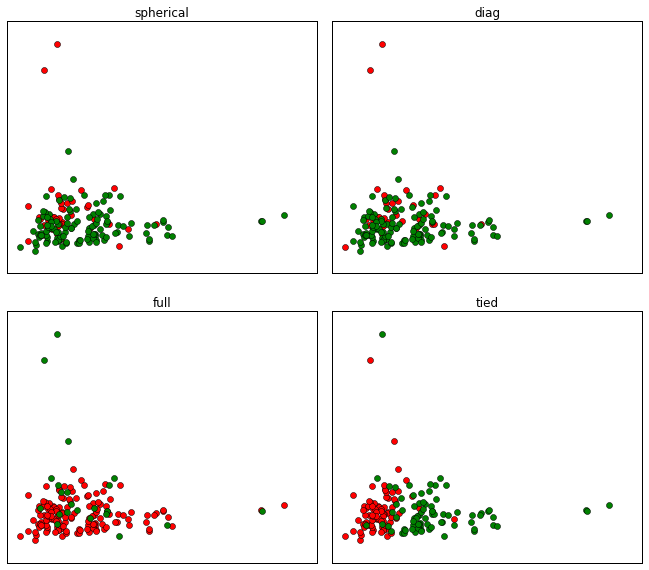

In [5]:
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold

#Try GMMs with different types of covariances
# How to find the best n_components
classifiers = dict((covar_type, GMM(n_components=2, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in ['spherical', 'diag', 'tied', 'full']);

n_classifiers = len(classifiers);

plt.figure(figsize = (6, 4));
for n, color in enumerate('rg'):
    visual = test_feature_two[test_target_two == n];
    plt.plot(visual[:, 0], visual[:, 1], 'o', color=color);
    
plt.title("Test data distribution");


plt.figure(figsize=(3 * n_classifiers * 0.75, 8));
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99);

for index, (name, clf) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, 
    # we can initialize the GMM parameters in a supervised manner.
    print (name, clf);
    
    clf.means_ = np.array([train_feature_two[train_target_two == user].mean(axis=0) for user in subjects_two]);

    # means_ : array, shape (n_components, n_features) Mean parameters for each mixture component.
    # axis : Axis or axes along which the means are computed. The default is to compute the mean of the flattened array. 
    # If this is a tuple of ints, a mean is performed over multiple axes, instead of a single axis or all the axes as before.
    # Compute the mean of features of every user seperately
    
    # Train the other parameters using the EM algorithm
    clf.fit(train_feature_two);
    
    plt.subplot(2, n_classifiers/2, index+1); #subplot(nrows, ncols, plot_number)
    
    train_pred = clf.predict(train_feature_two);
    test_pred = clf.predict(test_feature_two);
    train_accuracy = np.mean(train_pred == train_target_two)*100;
    test_accuracy = np.mean(test_pred == test_target_two)*100;
    print ("Train_accuracy", train_accuracy);
    print ("Test_accuracy", test_accuracy);

    # Visualization of the result
#     for n, color in enumerate('r'):
#         visual_test = test_feature_two[test_pred == n];
#         print visual_test.shape;
#         plt.plot(visual_test[0:40,0], 'o', color=color);   
    
    for n, color in enumerate('rg'):
        visual_test = test_feature_two[test_pred == n];
        print visual_test.shape;
        plt.plot(visual_test[:,0], visual_test[:,1], 'o', color=color);      
    
    plt.xticks(());
    plt.yticks(());
    plt.title(name);
     

sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
[[-36082.933366498139, -36245.756160184123, -36182.124851165776, -36331.831974127024, -36485.292944289366, -36620.65910989845, -36583.956339685872, -36629.318225165101, -37208.473185994299, -37137.90857082366], [-36082.933366498139, -36245.756160184123, -36182.124851165776, -36331.831974127024, -36485.292944289366, -36620.65910989845, -36583.956339685872, -36629.318225165101, -37208.473185994299, -37137.90857082366], [-36082.933366498139, -36245.756160184123, -36182.124851165776, -36331.831974127024, -36485.292944289366, -36620.65910989845, -36583.956339685872, -36629.318225165101, -37208.473185994299, -37137.90857082366], [-36082.933366498139, -36245.756160184123, -36182.124851165776, -36331.831974127024, -36485.292944289366, -36620.65910989845, -36583.956339685872, -36629.318225165101, -37208.473185994299, -37137.90857082366]]
[[-34097.02820171482, -34139.264723535402, -33955.04714265166, -33984.1679937

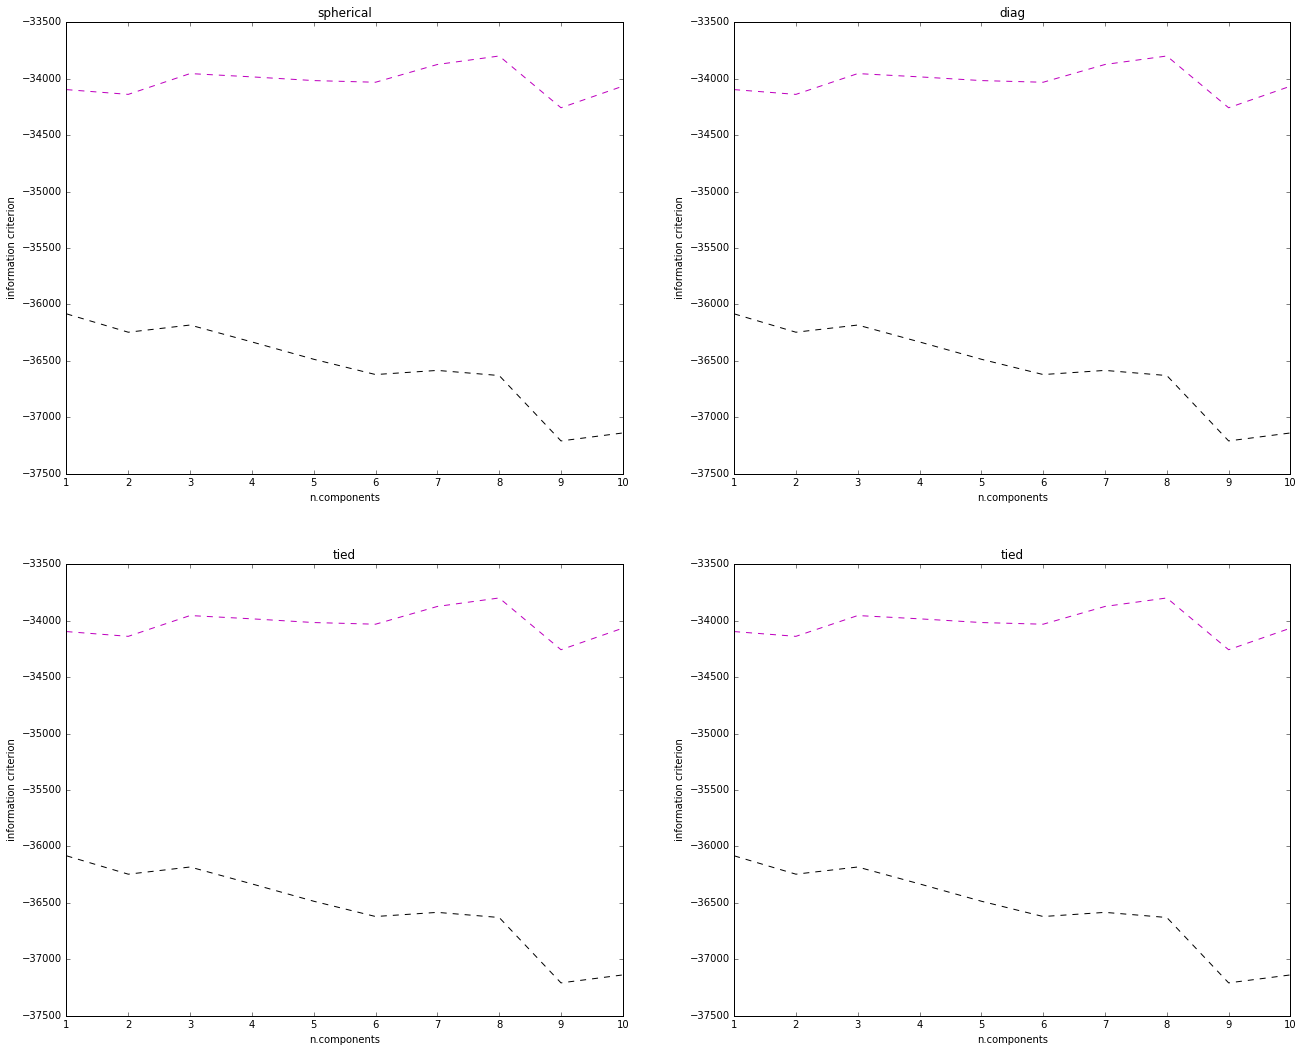

In [6]:

train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 5, True);

num_components = 11
covariances=('spherical', 'diag', 'tied', 'full');
models = np.array([dict((covar_type, GMM(n_components=i, covariance_type=covar_type)) 
                   for covar_type in covariances) for i in np.arange(1, num_components)]);

AIC = [[0]*(num_components-1)]*4
BIC = [[0]*(num_components-1)]*4

plt.figure(figsize=(20,20));
plt.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.2);

for n_components in range(10):
    for index, (name, model) in enumerate(models[n_components].items()):
#         print (name, model);
#         model.means_ = np.array([train_feature_user.mean(axis=0)]*(n_components+1));
        model.fit(train_feature_user);
        AIC[index][n_components] = model.aic(train_feature_user);
        BIC[index][n_components] = model.bic(train_feature_user);

print AIC;
print BIC;

plt.subplot(221);
plt.plot(np.arange(1,num_components), AIC[0], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[0], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("spherical");

plt.subplot(222);
plt.plot(np.arange(1,num_components), AIC[1], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[1], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("diag");

plt.subplot(223);
plt.plot(np.arange(1,num_components), AIC[2], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[2], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("tied");

plt.subplot(224);
plt.plot(np.arange(1,num_components), AIC[3], '--k', label = "AIC");
plt.plot(np.arange(1,num_components), BIC[3], '--m', label = "BIC");
plt.xlabel("n.components");
plt.ylabel("information criterion");
plt.title("tied");


In [7]:

import random

imposter_index = [random.randrange(400, len(train_feature), 13) for i in range(100)];
imposter_target = np.array([train_target[i] for i in imposter_index]); 
imposter_feature = np.array([train_feature[i] for i in imposter_index]);
print imposter_target;

feature_user = np.concatenate((train_feature_user, test_feature_user), axis=0);
genuine_index = [random.randrange(0, len(feature_user), 3) for i in range(100)];
genuine_user = np.array([feature_user[i] for i in genuine_index]);
print feature_user;

profiles = dict((covar_type, GMM(n_components=8, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in covariances);

model = profiles["diag"]
loo = cross_validation.LeaveOneOut(len(feature_user));
Scores = [];

for train_index, test_index in loo:
#     print("TRAIN: ", train_index, "TEST: ", test_index);
    train, test = feature_user[train_index], feature_user[test_index];
    model.fit(train);
    Scores.append(model.score(test));
    
Scores = np.array(Scores).ravel();
mean = np.mean(Scores);
std = np.std(Scores);
k = 0.4;
dis = [Scores[i] for i in range(len(Scores)) if abs(Scores[i]-mean) < k*std]; 
threshold_user = min(dis);

#print "Scores: ", Scores;
print "mean: ", mean, "std: ", std;
print threshold_user;

reject, accept = 0, 0;
model.fit(feature_user);
for i in range(len(imposter_feature)):
    score = model.score(imposter_feature[i]);
    distance = abs(score-mean);
#     print "score: ", score;
    if(score < threshold_user):
        reject = reject+1;
    else:
        accept = accept+1

FAR = accept;

reject, accept = 0, 0;
for i in range(len(genuine_user)):
    score = model.score(genuine_user[i]);
    distance = abs(score-mean);
#     print "score: ", score;
    if(score < threshold_user):
        reject = reject + 1;
    else:
        accept = accept + 1;

FRR = reject;
print "FAR: ", FAR;
print "FRR: ", FRR;
    

[ 44.   3.  41.  14.   7.  16.  48.  36.  34.  35.  40.  40.  46.  34.  50.
  47.   6.  41.   1.  12.   5.  49.  41.  27.   8.  26.  46.  43.  15.  26.
   5.  36.  29.  29.  16.  45.  16.  34.  27.  38.  44.  48.  46.  11.   6.
  32.  14.  14.  46.  49.  43.  14.  17.  12.  27.  24.  24.  32.  44.  44.
  11.  16.   7.  45.  38.  16.  15.  41.  30.  21.  47.  35.  43.   4.  17.
   5.  26.  15.   5.   2.  26.  29.  19.  11.  22.  17.  27.  14.  22.  24.
  44.  32.   4.  11.  38.  14.  31.  33.   8.  41.]
[[ 0.1491  0.3979  0.2488 ...,  0.3509  0.2171  0.0742]
 [ 0.1111  0.3451  0.234  ...,  0.2756  0.1917  0.0747]
 [ 0.1328  0.2072  0.0744 ...,  0.2847  0.1762  0.0945]
 ..., 
 [ 0.1557  0.2169  0.0612 ...,  0.2881  0.1614  0.127 ]
 [ 0.2072  0.2662  0.059  ...,  0.3018  0.1651  0.1246]
 [ 0.1642  0.175   0.0108 ...,  0.3048  0.1997  0.1259]]
mean:  55.5392399521 std:  10.3472238121
51.4624645109
FAR:  15
FRR:  24


D:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda2\lib\site-packages\skl

## Demonstration of Verification System
* Use HTML and Javascript build a front end page to simulate the login page of authentication system. Record what the user types in and extract keystroke features. (Front-End: HTML + Javascript)

* Back-end receive the keystroke information and pre-process it (Filter the mistake and extract the features in proper format). Use the model built with GMM+LOOM to verify the user. (Python)

* Back-end passes the verification result to front-end. Front-end visualizes the result whether user's authentication is successful.

In [8]:
from IPython.display import HTML


## Use this class to record the keystroke information from the front-end (Javascript)
class KeyEvent:
    keyCount = 0;
    
    def __init__(self, index, key, which, time_D, time_U):
        self.index = index; ## The index of pressing sequence
        self.key = key; 
        self.which = which; ## Keycode
        self.time_D = time_D;
        self.time_U = time_U;
        KeyEvent.keyCount += 1;
        
Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];
Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];

#### Front-End (HTML+Javascript)
   The front-end of this demo is written by html and javascript. For the convinence, I integrate the front-end code in notebook. With integrating back-end and front-end in one notebook, we can easily tune the algorithm and find the implicit problems in our system

In [18]:

%%html
<head>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1"/>
    <title>Keystroke demo</title>
    <script type="text/javascript" src="WebContent/js/UI.js"></script>
    <script type="text/javascript" src="WebContent/js/demo.js"></script>
    <link rel="stylesheet" type="text/css" href="WebContent/css/style_notebook.css"/>
</head>

<body id="body_inside">

    <h1 id="h1">Keystroke Demo</h1>
    <div class="target">
        <fieldset class="input">
            <label for="username" >Username:</label>
            <input id="username" type="text">
        </fieldset>
    
        <fieldset class="input">
            <label for="password">Password:</label>
            <input id="password" type="text">
        </fieldset>
    
        <button id="triger" onclick="exec_code()">Login</button>
    </div>
    
    <h2 id="h2">Output of Timestamp Data</h2>
    
    <div class="print-output">
        <fieldset class="output">
            <label for="Output">Output:</label>
            <input id="output" type="text" size="50"><br>
        </fieldset>
    </div>
    
    <script type="text/Javascript">
        function exec_code() {
            document.getElementById("output").value = Username;
            
            var kernel = IPython.notebook.kernel;
            
            kernel.execute("Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];");
            kernel.execute("Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];");

            
            for(i = 0; i < Feature_Username.length; i++) {
                var command_index = "Username_index.append(" + Feature_Username[i].index + ")";
                var command_key = "Username_key.append('" + Feature_Username[i].key + "')";
                var command_which = "Username_which.append(" + Feature_Username[i].which + ")";
                var command_time_D = "Username_time_D.append(" + Feature_Username[i].time_D + ")";
                var command_time_U = "Username_time_U.append(" + Feature_Username[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
            }
            
            for(i = 0; i < Feature_Password.length; i++) {
                var command_index = "Password_index.append(" + Feature_Password[i].index + ")";
                var command_key = "Password_key.append('" + Feature_Password[i].key + "')";
                var command_which = "Password_which.append(" + Feature_Password[i].which + ")";
                var command_time_D = "Password_time_D.append(" + Feature_Password[i].time_D + ")";
                var command_time_U = "Password_time_U.append(" + Feature_Password[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
            }
            
            //var command = "Index = [Released_Key[i].index for i in range("+Released_Key.length+")]";
            
            //console.log("Executing Command: " + command);
            //kernel.execute(command);
            
            //var command_test_2 = "Index = " + Released_Key[0].index;
            //kernel.execute(command_test_2);
        }
        
    </script>
    
</body>

* The function "RemoveMistake" is used for the user's typing mistake. Typing mistake means the mistake that users make while typing their username and password. Generally, if users make some typing mistakes, they will delete mistakes and type in again.
* So we should filter the typing mistakes and extract the effective typed charactors.

In [10]:
def RemoveMistake(Content):
    ## Deal with typing mistake and generate feature vector
    ## Backspace: 8

    length = len(Content);
    i = 0;
    while(i < length):
        print i, length, Content[i].key;
        item = Content[i];
        if(item.which == 8):
            ## remove Backspace and other keys that user deletes because of mistake
            ## if find a Backspace, delete the Backspace and the key in front of it
            ## additional Backspace: only remove Backspace
            if(i == 0):
                del Content[i];
                length -= 1;
                i -= 1;
            ## remove the Backspace and wrong characters
            else:
                ## remove all the other non-printable char before the Backspace
                which = Content[i-1].which;
                while(which < 48 or (which>90 and which<96) or (which>111 and which<186)):
                    print i, Content[i-1].key, which;
                    del Content[i-1];
                    i -= 1; length -= 1;
                    which = Content[i-1].which;
                    
                ## remove the printable char that should be remove by this Backspace    
                del Content[i-1:i+1];
                length -= 2;
                i -= 2;
        i += 1;

#### Extract and generate feature vector from the what user types in the front-end
   * Extract hold-time, DDKL, UDKL, UUKL.
   * One important point is that, the sequence of key-press and key-release could be a chaos. So we should generate thefeature vector with a predefine format. This format depends on user's true username and password.

In [13]:

## Generate the format of feature vector. We build the feature vector according to the format of CMU dataset (H, DD, UD...)
## In the next step, we will calculate each feature's value and fill this vector with those values
Username = "Amadeus"
Password = ".tie5Roanl"

User = "Pysherlock"
Pwd = "Batman&Superman"


In [22]:
##Deal with the features extracted by the front-end

print Username[3], Password[0], User[0], Pwd[6];

print type(Username_index), Username_index;
print type(Username_key), Username_key;
print type(Username_which), Username_which;
print type(Username_time_D), Username_time_D;
print type(Username_time_U), Username_time_U;


Username_keyevent = [KeyEvent(Username_index[i], Username_key[i], Username_which[i], 
                     Username_time_D[i], Username_time_U[i]) for i in range(len(Username_index))];

Password_keyevent = [KeyEvent(Password_index[i], Password_key[i], Password_which[i], 
                     Password_time_D[i], Password_time_U[i]) for i in range(len(Password_index))];


## Deal with typing mistake and generate feature vector

## sort by pressed index. The orginal vector is in sequence of release
Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);

RemoveMistake(Press_Sequence_Username);
RemoveMistake(Press_Sequence_Username);

print "Release Sequence";
print [Username_keyevent[i].key for i in range(len(Username_keyevent))];
print [Username_keyevent[i].index for i in range(len(Username_keyevent))];

# print [Password_keyevent[i].key for i in range(len(Password_keyevent))];
# print [Password_keyevent[i].index for i in range(len(Username_keyevent))];

print "Press Sequence";
print [Press_Sequence_Username[i].key for i in range(len(Press_Sequence_Username))];
print [Press_Sequence_Username[i].index for i in range(len(Press_Sequence_Username))];

## Generate feature vector, four kinds of features: hold-time, DDKL, UDKL, UUKL
H_time_Username = [Press_Sequence_Username[i].time_U - Press_Sequence_Username[i].time_D 
                   for i in range(len(Press_Sequence_Username))];
H_time_Password = [Press_Sequence_Password[i].time_U - Press_Sequence_Password[i].time_D 
                   for i in range(len(Press_Sequence_Password))];

DDKL_Username = [Press_Sequence_Username[i+1].time_D - Press_Sequence_Username[i].time_D 
                 for i in range(len(Press_Sequence_Username)-1)];
DDKL_Password = [Press_Sequence_Password[i+1].time_D - Press_Sequence_Password[i].time_D
                 for i in range(len(Press_Sequence_Password)-1)];

UDKL_Username = [Press_Sequence_Username[i+1].time_D - Press_Sequence_Username[i].time_U 
                 for i in range(len(Press_Sequence_Username)-1)];
UDKL_Password = [Press_Sequence_Password[i+1].time_D - Press_Sequence_Password[i].time_U 
                 for i in range(len(Press_Sequence_Password)-1)];

UUKL_Username = [Press_Sequence_Username[i+1].time_U - Press_Sequence_Username[i].time_U 
                 for i in range(len(Press_Sequence_Username)-1)];
UUKL_Password = [Press_Sequence_Password[i+1].time_U - Press_Sequence_Password[i].time_U 
                 for i in range(len(Press_Sequence_Password)-1)];

print H_time_Username;
print DDKL_Username;
print UDKL_Username;
print UUKL_Username;

d . P &
<type 'list'> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
<type 'list'> ['Shift', 'A', 'm', 's', 'j', 'f', 'b', 'z', '-', '=', 'Delete', 'Home', 'End', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'm', 'a', 'd', 'e', 'u', 's']
<type 'list'> [16, 65, 77, 83, 74, 70, 66, 90, 189, 187, 46, 36, 35, 8, 8, 8, 8, 8, 8, 8, 8, 77, 65, 68, 69, 85, 83]
<type 'list'> [421389.43000000005, 421701.1450000001, 421901.99500000005, 422189.23500000004, 422389.25500000006, 422566.025, 422757.61000000004, 422982.39, 423309.12, 423637.275, 424061.435, 424333.87000000005, 424565.36000000004, 425534.16500000004, 425718.56, 425901.21, 426070.18000000005, 426245.35000000003, 426429.23500000004, 426605.17000000004, 427005.24500000005, 427974.24500000005, 428079.57000000007, 428950.09500000003, 429165.085, 429574.015, 429694.29000000004]
<type 'list'> [421845.56000000006, 421845.765, 421997.37